In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as çflt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)

2023-01-24 19:16:09.857830: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Data augmentation

In [ ]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=1,var1_u=10,CROP1=CROP,BATCH_SIZE=5)

In [20]:
xs, ys = next(gen_batch_train.as_numpy_iterator())

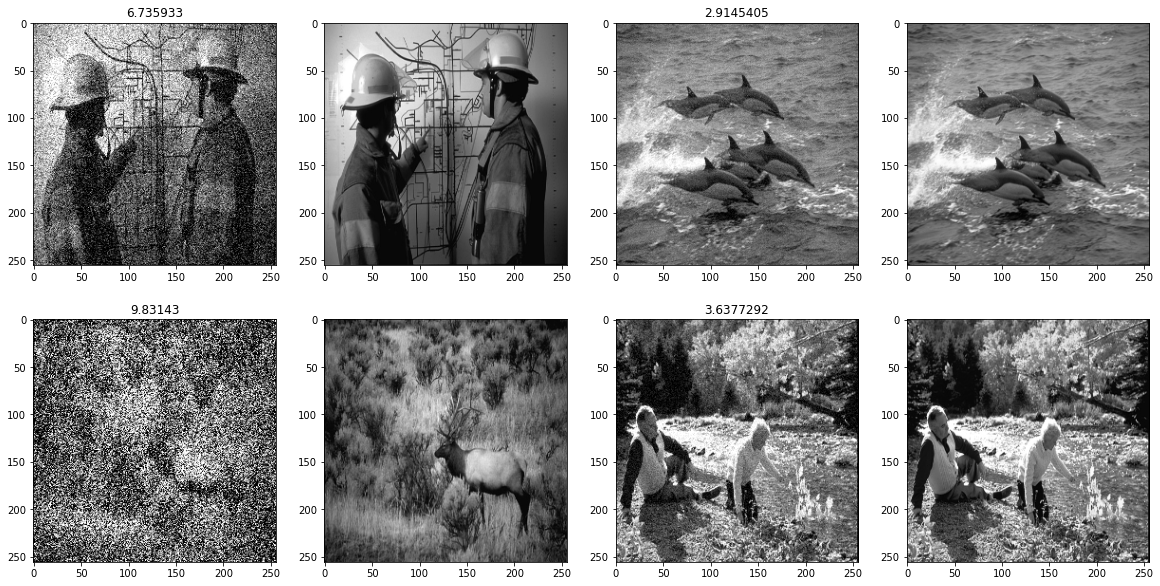

In [21]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs['input']))
        axs[i,2*j].imshow(np.squeeze(xs['input'][_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        axs[i,2*j].set_title(str(np.mean(xs['input_emb'][_])))
        
plt.show()

# Neural networks

In [23]:
strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.OneDeviceStrategy('/device:GPU:0')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [6]:
order = 1
num_classes = 50
model = get_model("splines",it_lim=10,image_size=image_size,num_classes = num_classes,order=order)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='mse',)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Training

In [31]:
order = 1
for num_classes in [10,15,20,50]:
    print('num_classes: ',num_classes)
    model = get_model("splines",it_lim=10,image_size=image_size,num_classes = num_classes,order=order)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
            loss='mse',)
    
    callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath= f"./checkpoints/splines_{typ}_{num_classes}",
    save_weights_only=True,
    verbose = True,
    save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1)
    ]
    
    history = model.fit(
        gen_batch_train,
        epochs=100,
        steps_per_epoch=10,
        validation_data=gen_batch_val,
        validation_steps=5,
        shuffle=False,
        use_multiprocessing=True,
        callbacks=callbacks,
        workers=1
    )
    
    np.save(f'./history/splines_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))

num_classes:  10
Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.0720
Epoch 00001: val_loss improved from inf to 0.03154, saving model to ./checkpoints/splines_gaussian_10
10/10 [==============================] - 11s 751ms/step - loss: 0.0720 - val_loss: 0.0315 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0663
Epoch 00002: val_loss improved from 0.03154 to 0.02850, saving model to ./checkpoints/splines_gaussian_10
10/10 [==============================] - 6s 668ms/step - loss: 0.0663 - val_loss: 0.0285 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0611
Epoch 00003: val_loss improved from 0.02850 to 0.02386, saving model to ./checkpoints/splines_gaussian_10
10/10 [==============================] - 6s 659ms/step - loss: 0.0611 - val_loss: 0.0239 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0614
Epoch 00004: val_loss did not improve from 0.02386
10/10 [

Epoch 35/100
10/10 [==============================] - ETA: 0s - loss: 0.0371
Epoch 00035: val_loss did not improve from 0.02386
10/10 [==============================] - 6s 638ms/step - loss: 0.0371 - val_loss: 0.0321 - lr: 8.0000e-06
Epoch 36/100
10/10 [==============================] - ETA: 0s - loss: 0.0373
Epoch 00036: val_loss did not improve from 0.02386
10/10 [==============================] - 6s 645ms/step - loss: 0.0373 - val_loss: 0.0384 - lr: 8.0000e-06
Epoch 37/100
10/10 [==============================] - ETA: 0s - loss: 0.0382
Epoch 00037: val_loss did not improve from 0.02386
10/10 [==============================] - 6s 641ms/step - loss: 0.0382 - val_loss: 0.0441 - lr: 8.0000e-06
Epoch 38/100
10/10 [==============================] - ETA: 0s - loss: 0.0332
Epoch 00038: val_loss did not improve from 0.02386
10/10 [==============================] - 6s 647ms/step - loss: 0.0332 - val_loss: 0.0369 - lr: 8.0000e-06
Epoch 39/100
10/10 [==============================] - ETA: 0s - 

Epoch 69/100
10/10 [==============================] - ETA: 0s - loss: 0.0320
Epoch 00069: val_loss did not improve from 0.02386
10/10 [==============================] - 6s 634ms/step - loss: 0.0320 - val_loss: 0.0325 - lr: 6.4000e-08
Epoch 70/100
10/10 [==============================] - ETA: 0s - loss: 0.0362
Epoch 00070: val_loss did not improve from 0.02386
10/10 [==============================] - 6s 641ms/step - loss: 0.0362 - val_loss: 0.0303 - lr: 6.4000e-08
Epoch 71/100
10/10 [==============================] - ETA: 0s - loss: 0.0377
Epoch 00071: val_loss did not improve from 0.02386
10/10 [==============================] - 6s 634ms/step - loss: 0.0377 - val_loss: 0.0315 - lr: 6.4000e-08
Epoch 72/100
10/10 [==============================] - ETA: 0s - loss: 0.0377
Epoch 00072: val_loss did not improve from 0.02386
10/10 [==============================] - 6s 655ms/step - loss: 0.0377 - val_loss: 0.0374 - lr: 6.4000e-08
Epoch 73/100
10/10 [==============================] - ETA: 0s - 

Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0312
Epoch 00003: val_loss improved from 0.02725 to 0.02611, saving model to ./checkpoints/splines_gaussian_15
10/10 [==============================] - 7s 681ms/step - loss: 0.0312 - val_loss: 0.0261 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0301
Epoch 00004: val_loss did not improve from 0.02611
10/10 [==============================] - 6s 665ms/step - loss: 0.0301 - val_loss: 0.0273 - lr: 0.0010
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 0.0289
Epoch 00005: val_loss did not improve from 0.02611
10/10 [==============================] - 6s 663ms/step - loss: 0.0289 - val_loss: 0.0274 - lr: 0.0010
Epoch 6/100
10/10 [==============================] - ETA: 0s - loss: 0.0282
Epoch 00006: val_loss did not improve from 0.02611
10/10 [==============================] - 6s 654ms/step - loss: 0.0282 - val_loss: 0.0264 - lr: 0.0010
Epoch 7/100
10/10 [==========

Epoch 37/100
10/10 [==============================] - ETA: 0s - loss: 0.0266
Epoch 00037: val_loss did not improve from 0.02185
10/10 [==============================] - 7s 672ms/step - loss: 0.0266 - val_loss: 0.0278 - lr: 4.0000e-05
Epoch 38/100
10/10 [==============================] - ETA: 0s - loss: 0.0280
Epoch 00038: val_loss did not improve from 0.02185
10/10 [==============================] - 7s 671ms/step - loss: 0.0280 - val_loss: 0.0277 - lr: 4.0000e-05
Epoch 39/100
10/10 [==============================] - ETA: 0s - loss: 0.0278
Epoch 00039: val_loss did not improve from 0.02185
10/10 [==============================] - 6s 662ms/step - loss: 0.0278 - val_loss: 0.0285 - lr: 4.0000e-05
Epoch 40/100
10/10 [==============================] - ETA: 0s - loss: 0.0262
Epoch 00040: val_loss did not improve from 0.02185
10/10 [==============================] - 6s 661ms/step - loss: 0.0262 - val_loss: 0.0279 - lr: 4.0000e-05
Epoch 41/100
10/10 [==============================] - ETA: 0s - 

Epoch 71/100
10/10 [==============================] - ETA: 0s - loss: 0.0271
Epoch 00071: val_loss did not improve from 0.02185
10/10 [==============================] - 7s 676ms/step - loss: 0.0271 - val_loss: 0.0275 - lr: 3.2000e-07
Epoch 72/100
10/10 [==============================] - ETA: 0s - loss: 0.0269
Epoch 00072: val_loss did not improve from 0.02185
10/10 [==============================] - 7s 679ms/step - loss: 0.0269 - val_loss: 0.0225 - lr: 3.2000e-07
Epoch 73/100
10/10 [==============================] - ETA: 0s - loss: 0.0256
Epoch 00073: val_loss did not improve from 0.02185
10/10 [==============================] - 6s 662ms/step - loss: 0.0256 - val_loss: 0.0271 - lr: 3.2000e-07
Epoch 74/100
10/10 [==============================] - ETA: 0s - loss: 0.0289
Epoch 00074: val_loss did not improve from 0.02185
10/10 [==============================] - 7s 671ms/step - loss: 0.0289 - val_loss: 0.0271 - lr: 3.2000e-07
Epoch 75/100
10/10 [==============================] - ETA: 0s - 

Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 0.0305
Epoch 00005: val_loss did not improve from 0.02310
10/10 [==============================] - 6s 647ms/step - loss: 0.0305 - val_loss: 0.0299 - lr: 0.0010
Epoch 6/100
10/10 [==============================] - ETA: 0s - loss: 0.0270
Epoch 00006: val_loss did not improve from 0.02310
10/10 [==============================] - 6s 652ms/step - loss: 0.0270 - val_loss: 0.0281 - lr: 0.0010
Epoch 7/100
10/10 [==============================] - ETA: 0s - loss: 0.0330
Epoch 00007: val_loss did not improve from 0.02310
10/10 [==============================] - 6s 661ms/step - loss: 0.0330 - val_loss: 0.0401 - lr: 0.0010
Epoch 8/100
10/10 [==============================] - ETA: 0s - loss: 0.0322
Epoch 00008: val_loss did not improve from 0.02310
10/10 [==============================] - 6s 658ms/step - loss: 0.0322 - val_loss: 0.0314 - lr: 0.0010
Epoch 9/100
10/10 [==============================] - ETA: 0s - loss: 0.0304
Epoch 00

Epoch 73/100
10/10 [==============================] - ETA: 0s - loss: 0.0257
Epoch 00073: val_loss did not improve from 0.02254
10/10 [==============================] - 6s 663ms/step - loss: 0.0257 - val_loss: 0.0307 - lr: 6.4000e-08
Epoch 74/100
10/10 [==============================] - ETA: 0s - loss: 0.0256
Epoch 00074: val_loss did not improve from 0.02254
10/10 [==============================] - 7s 676ms/step - loss: 0.0256 - val_loss: 0.0317 - lr: 6.4000e-08
Epoch 75/100
10/10 [==============================] - ETA: 0s - loss: 0.0312
Epoch 00075: val_loss did not improve from 0.02254
10/10 [==============================] - 6s 656ms/step - loss: 0.0312 - val_loss: 0.0299 - lr: 6.4000e-08
Epoch 76/100
10/10 [==============================] - ETA: 0s - loss: 0.0268
Epoch 00076: val_loss did not improve from 0.02254
10/10 [==============================] - 6s 660ms/step - loss: 0.0268 - val_loss: 0.0255 - lr: 6.4000e-08
Epoch 77/100
10/10 [==============================] - ETA: 0s - 

Epoch 7/100
10/10 [==============================] - ETA: 0s - loss: 0.0241
Epoch 00007: val_loss did not improve from 0.02244
10/10 [==============================] - 7s 720ms/step - loss: 0.0241 - val_loss: 0.0242 - lr: 0.0010
Epoch 8/100
10/10 [==============================] - ETA: 0s - loss: 0.0244
Epoch 00008: val_loss did not improve from 0.02244
10/10 [==============================] - 7s 726ms/step - loss: 0.0244 - val_loss: 0.0301 - lr: 0.0010
Epoch 9/100
10/10 [==============================] - ETA: 0s - loss: 0.0292
Epoch 00009: val_loss did not improve from 0.02244
10/10 [==============================] - 7s 708ms/step - loss: 0.0292 - val_loss: 0.0293 - lr: 0.0010
Epoch 10/100
10/10 [==============================] - ETA: 0s - loss: 0.0240
Epoch 00010: val_loss did not improve from 0.02244
10/10 [==============================] - 7s 720ms/step - loss: 0.0240 - val_loss: 0.0269 - lr: 0.0010
Epoch 11/100
10/10 [==============================] - ETA: 0s - loss: 0.0253
Epoch 

Epoch 41/100
10/10 [==============================] - ETA: 0s - loss: 0.0264
Epoch 00041: val_loss did not improve from 0.02240
10/10 [==============================] - 7s 713ms/step - loss: 0.0264 - val_loss: 0.0236 - lr: 8.0000e-06
Epoch 42/100
10/10 [==============================] - ETA: 0s - loss: 0.0280
Epoch 00042: val_loss did not improve from 0.02240

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
10/10 [==============================] - 7s 713ms/step - loss: 0.0280 - val_loss: 0.0246 - lr: 8.0000e-06
Epoch 43/100
10/10 [==============================] - ETA: 0s - loss: 0.0258
Epoch 00043: val_loss did not improve from 0.02240
10/10 [==============================] - 7s 707ms/step - loss: 0.0258 - val_loss: 0.0252 - lr: 1.6000e-06
Epoch 44/100
10/10 [==============================] - ETA: 0s - loss: 0.0287
Epoch 00044: val_loss did not improve from 0.02240
10/10 [==============================] - 7s 716ms/step - loss: 0.0287 - val_loss: 0.0253

Epoch 75/100
10/10 [==============================] - ETA: 0s - loss: 0.0272
Epoch 00075: val_loss did not improve from 0.02124
10/10 [==============================] - 7s 721ms/step - loss: 0.0272 - val_loss: 0.0279 - lr: 6.4000e-08
Epoch 76/100
10/10 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00076: val_loss did not improve from 0.02124

Epoch 00076: ReduceLROnPlateau reducing learning rate to 1.2800001059076749e-08.
10/10 [==============================] - 7s 715ms/step - loss: 0.0285 - val_loss: 0.0258 - lr: 6.4000e-08
Epoch 77/100
10/10 [==============================] - ETA: 0s - loss: 0.0248
Epoch 00077: val_loss did not improve from 0.02124
10/10 [==============================] - 7s 711ms/step - loss: 0.0248 - val_loss: 0.0296 - lr: 1.2800e-08
Epoch 78/100
10/10 [==============================] - ETA: 0s - loss: 0.0262
Epoch 00078: val_loss did not improve from 0.02124
10/10 [==============================] - 7s 720ms/step - loss: 0.0262 - val_loss: 0.0219

In [32]:
order = 1
for num_classes in [5,10,15,20,50]:
    print('num_classes: ',num_classes)
    model = get_model("simple_splines",it_lim=10,image_size=image_size,num_classes = num_classes,order=order)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
            loss='mse',)
    
    callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath= f"./checkpoints/simplesplines_{typ}_{num_classes}",
    save_weights_only=True,
    verbose = True,
    save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1)
    ]
    
    history = model.fit(
        gen_batch_train,
        epochs=100,
        steps_per_epoch=10,
        validation_data=gen_batch_val,
        validation_steps=5,
        shuffle=False,
        use_multiprocessing=True,
        callbacks=callbacks,
        workers=1
    )
    
    np.save(f'./history/simplesplines_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))

num_classes:  5
Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.0518
Epoch 00001: val_loss improved from inf to 0.03272, saving model to ./checkpoints/simplesplines_gaussian_5
10/10 [==============================] - 9s 627ms/step - loss: 0.0518 - val_loss: 0.0327 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0259
Epoch 00002: val_loss improved from 0.03272 to 0.02327, saving model to ./checkpoints/simplesplines_gaussian_5
10/10 [==============================] - 6s 582ms/step - loss: 0.0259 - val_loss: 0.0233 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0222
Epoch 00003: val_loss improved from 0.02327 to 0.02099, saving model to ./checkpoints/simplesplines_gaussian_5
10/10 [==============================] - 6s 580ms/step - loss: 0.0222 - val_loss: 0.0210 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0216
Epoch 00004: val_loss improved from 0.02099 t

Epoch 34/100
10/10 [==============================] - ETA: 0s - loss: 0.0215
Epoch 00034: val_loss did not improve from 0.01646
10/10 [==============================] - 5s 560ms/step - loss: 0.0215 - val_loss: 0.0180 - lr: 2.0000e-04
Epoch 35/100
10/10 [==============================] - ETA: 0s - loss: 0.0231
Epoch 00035: val_loss did not improve from 0.01646
10/10 [==============================] - 5s 558ms/step - loss: 0.0231 - val_loss: 0.0246 - lr: 2.0000e-04
Epoch 36/100
10/10 [==============================] - ETA: 0s - loss: 0.0219
Epoch 00036: val_loss did not improve from 0.01646
10/10 [==============================] - 5s 554ms/step - loss: 0.0219 - val_loss: 0.0248 - lr: 2.0000e-04
Epoch 37/100
10/10 [==============================] - ETA: 0s - loss: 0.0232
Epoch 00037: val_loss did not improve from 0.01646
10/10 [==============================] - 5s 564ms/step - loss: 0.0232 - val_loss: 0.0230 - lr: 2.0000e-04
Epoch 38/100
10/10 [==============================] - ETA: 0s - 

Epoch 68/100
10/10 [==============================] - ETA: 0s - loss: 0.0227
Epoch 00068: val_loss did not improve from 0.01646
10/10 [==============================] - 5s 564ms/step - loss: 0.0227 - val_loss: 0.0191 - lr: 1.6000e-06
Epoch 69/100
10/10 [==============================] - ETA: 0s - loss: 0.0247
Epoch 00069: val_loss did not improve from 0.01646
10/10 [==============================] - 5s 568ms/step - loss: 0.0247 - val_loss: 0.0241 - lr: 1.6000e-06
Epoch 70/100
10/10 [==============================] - ETA: 0s - loss: 0.0212
Epoch 00070: val_loss did not improve from 0.01646
10/10 [==============================] - 5s 555ms/step - loss: 0.0212 - val_loss: 0.0239 - lr: 1.6000e-06
Epoch 71/100
10/10 [==============================] - ETA: 0s - loss: 0.0208
Epoch 00071: val_loss did not improve from 0.01646
10/10 [==============================] - 5s 558ms/step - loss: 0.0208 - val_loss: 0.0219 - lr: 1.6000e-06
Epoch 72/100
10/10 [==============================] - ETA: 0s - 

Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0227
Epoch 00002: val_loss did not improve from 0.02147
10/10 [==============================] - 6s 578ms/step - loss: 0.0227 - val_loss: 0.0255 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0288
Epoch 00003: val_loss did not improve from 0.02147
10/10 [==============================] - 6s 579ms/step - loss: 0.0288 - val_loss: 0.0248 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0250
Epoch 00004: val_loss did not improve from 0.02147
10/10 [==============================] - 6s 581ms/step - loss: 0.0250 - val_loss: 0.0267 - lr: 0.0010
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 0.0269
Epoch 00005: val_loss did not improve from 0.02147
10/10 [==============================] - 6s 579ms/step - loss: 0.0269 - val_loss: 0.0224 - lr: 0.0010
Epoch 6/100
10/10 [==============================] - ETA: 0s - loss: 0.0243
Epoch 00

Epoch 36/100
10/10 [==============================] - ETA: 0s - loss: 0.0256
Epoch 00036: val_loss did not improve from 0.01943
10/10 [==============================] - 6s 577ms/step - loss: 0.0256 - val_loss: 0.0231 - lr: 4.0000e-05
Epoch 37/100
10/10 [==============================] - ETA: 0s - loss: 0.0239
Epoch 00037: val_loss did not improve from 0.01943
10/10 [==============================] - 6s 579ms/step - loss: 0.0239 - val_loss: 0.0230 - lr: 4.0000e-05
Epoch 38/100
10/10 [==============================] - ETA: 0s - loss: 0.0262
Epoch 00038: val_loss did not improve from 0.01943
10/10 [==============================] - 6s 573ms/step - loss: 0.0262 - val_loss: 0.0251 - lr: 4.0000e-05
Epoch 39/100
10/10 [==============================] - ETA: 0s - loss: 0.0268
Epoch 00039: val_loss did not improve from 0.01943

Epoch 00039: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
10/10 [==============================] - 6s 575ms/step - loss: 0.0268 - val_loss: 0.0227 

Epoch 70/100
10/10 [==============================] - ETA: 0s - loss: 0.0231
Epoch 00070: val_loss did not improve from 0.01943
10/10 [==============================] - 6s 576ms/step - loss: 0.0231 - val_loss: 0.0241 - lr: 6.4000e-08
Epoch 71/100
10/10 [==============================] - ETA: 0s - loss: 0.0257
Epoch 00071: val_loss did not improve from 0.01943
10/10 [==============================] - 6s 592ms/step - loss: 0.0257 - val_loss: 0.0266 - lr: 6.4000e-08
Epoch 72/100
10/10 [==============================] - ETA: 0s - loss: 0.0242
Epoch 00072: val_loss did not improve from 0.01943
10/10 [==============================] - 6s 578ms/step - loss: 0.0242 - val_loss: 0.0275 - lr: 6.4000e-08
Epoch 73/100
10/10 [==============================] - ETA: 0s - loss: 0.0277
Epoch 00073: val_loss did not improve from 0.01943
10/10 [==============================] - 6s 578ms/step - loss: 0.0277 - val_loss: 0.0291 - lr: 6.4000e-08
Epoch 74/100
10/10 [==============================] - ETA: 0s - 

Epoch 37/100
10/10 [==============================] - ETA: 0s - loss: 0.0255
Epoch 00037: val_loss did not improve from 0.01917
10/10 [==============================] - 6s 594ms/step - loss: 0.0255 - val_loss: 0.0224 - lr: 2.0000e-04
Epoch 38/100
10/10 [==============================] - ETA: 0s - loss: 0.0211
Epoch 00038: val_loss improved from 0.01917 to 0.01903, saving model to ./checkpoints/simplesplines_gaussian_15
10/10 [==============================] - 6s 605ms/step - loss: 0.0211 - val_loss: 0.0190 - lr: 2.0000e-04
Epoch 39/100
10/10 [==============================] - ETA: 0s - loss: 0.0220
Epoch 00039: val_loss did not improve from 0.01903
10/10 [==============================] - 6s 582ms/step - loss: 0.0220 - val_loss: 0.0251 - lr: 2.0000e-04
Epoch 40/100
10/10 [==============================] - ETA: 0s - loss: 0.0202
Epoch 00040: val_loss did not improve from 0.01903
10/10 [==============================] - 6s 589ms/step - loss: 0.0202 - val_loss: 0.0271 - lr: 2.0000e-04
Epo

Epoch 71/100
10/10 [==============================] - ETA: 0s - loss: 0.0236
Epoch 00071: val_loss did not improve from 0.01799
10/10 [==============================] - 6s 590ms/step - loss: 0.0236 - val_loss: 0.0205 - lr: 8.0000e-06
Epoch 72/100
10/10 [==============================] - ETA: 0s - loss: 0.0220
Epoch 00072: val_loss did not improve from 0.01799
10/10 [==============================] - 6s 596ms/step - loss: 0.0220 - val_loss: 0.0238 - lr: 8.0000e-06
Epoch 73/100
10/10 [==============================] - ETA: 0s - loss: 0.0233
Epoch 00073: val_loss did not improve from 0.01799
10/10 [==============================] - 6s 677ms/step - loss: 0.0233 - val_loss: 0.0197 - lr: 8.0000e-06
Epoch 74/100
10/10 [==============================] - ETA: 0s - loss: 0.0231
Epoch 00074: val_loss did not improve from 0.01799
10/10 [==============================] - 6s 628ms/step - loss: 0.0231 - val_loss: 0.0232 - lr: 8.0000e-06
Epoch 75/100
10/10 [==============================] - ETA: 0s - 

Epoch 38/100
10/10 [==============================] - ETA: 0s - loss: 0.0227
Epoch 00038: val_loss did not improve from 0.01707

Epoch 00038: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
10/10 [==============================] - 6s 589ms/step - loss: 0.0227 - val_loss: 0.0202 - lr: 4.0000e-05
Epoch 39/100
10/10 [==============================] - ETA: 0s - loss: 0.0240
Epoch 00039: val_loss did not improve from 0.01707
10/10 [==============================] - 6s 592ms/step - loss: 0.0240 - val_loss: 0.0213 - lr: 8.0000e-06
Epoch 40/100
10/10 [==============================] - ETA: 0s - loss: 0.0193
Epoch 00040: val_loss did not improve from 0.01707
10/10 [==============================] - 6s 586ms/step - loss: 0.0193 - val_loss: 0.0208 - lr: 8.0000e-06
Epoch 41/100
10/10 [==============================] - ETA: 0s - loss: 0.0242
Epoch 00041: val_loss did not improve from 0.01707
10/10 [==============================] - 6s 604ms/step - loss: 0.0242 - val_loss: 0.0245 

Epoch 72/100
10/10 [==============================] - ETA: 0s - loss: 0.0258
Epoch 00072: val_loss did not improve from 0.01707
10/10 [==============================] - 6s 607ms/step - loss: 0.0258 - val_loss: 0.0234 - lr: 6.4000e-08
Epoch 73/100
10/10 [==============================] - ETA: 0s - loss: 0.0227
Epoch 00073: val_loss did not improve from 0.01707
10/10 [==============================] - 6s 596ms/step - loss: 0.0227 - val_loss: 0.0220 - lr: 6.4000e-08
Epoch 74/100
10/10 [==============================] - ETA: 0s - loss: 0.0238
Epoch 00074: val_loss did not improve from 0.01707
10/10 [==============================] - 6s 604ms/step - loss: 0.0238 - val_loss: 0.0252 - lr: 6.4000e-08
Epoch 75/100
10/10 [==============================] - ETA: 0s - loss: 0.0232
Epoch 00075: val_loss did not improve from 0.01707
10/10 [==============================] - 6s 608ms/step - loss: 0.0232 - val_loss: 0.0196 - lr: 6.4000e-08
Epoch 76/100
10/10 [==============================] - ETA: 0s - 

10/10 [==============================] - ETA: 0s - loss: 0.0240
Epoch 00039: val_loss did not improve from 0.01913
10/10 [==============================] - 6s 647ms/step - loss: 0.0240 - val_loss: 0.0253 - lr: 4.0000e-05
Epoch 40/100
10/10 [==============================] - ETA: 0s - loss: 0.0223
Epoch 00040: val_loss did not improve from 0.01913
10/10 [==============================] - 6s 653ms/step - loss: 0.0223 - val_loss: 0.0246 - lr: 4.0000e-05
Epoch 41/100
10/10 [==============================] - ETA: 0s - loss: 0.0223
Epoch 00041: val_loss did not improve from 0.01913

Epoch 00041: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
10/10 [==============================] - 6s 648ms/step - loss: 0.0223 - val_loss: 0.0253 - lr: 4.0000e-05
Epoch 42/100
10/10 [==============================] - ETA: 0s - loss: 0.0223
Epoch 00042: val_loss did not improve from 0.01913
10/10 [==============================] - 6s 651ms/step - loss: 0.0223 - val_loss: 0.0212 - lr: 8.0000e

Epoch 73/100
10/10 [==============================] - ETA: 0s - loss: 0.0237
Epoch 00073: val_loss did not improve from 0.01850
10/10 [==============================] - 6s 648ms/step - loss: 0.0237 - val_loss: 0.0191 - lr: 3.2000e-07
Epoch 74/100
10/10 [==============================] - ETA: 0s - loss: 0.0205
Epoch 00074: val_loss did not improve from 0.01850
10/10 [==============================] - 6s 669ms/step - loss: 0.0205 - val_loss: 0.0224 - lr: 3.2000e-07
Epoch 75/100
10/10 [==============================] - ETA: 0s - loss: 0.0220
Epoch 00075: val_loss did not improve from 0.01850

Epoch 00075: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
10/10 [==============================] - 6s 648ms/step - loss: 0.0220 - val_loss: 0.0218 - lr: 3.2000e-07
Epoch 76/100
10/10 [==============================] - ETA: 0s - loss: 0.0253
Epoch 00076: val_loss did not improve from 0.01850
10/10 [==============================] - 6s 658ms/step - loss: 0.0253 - val_loss: 0.0242 

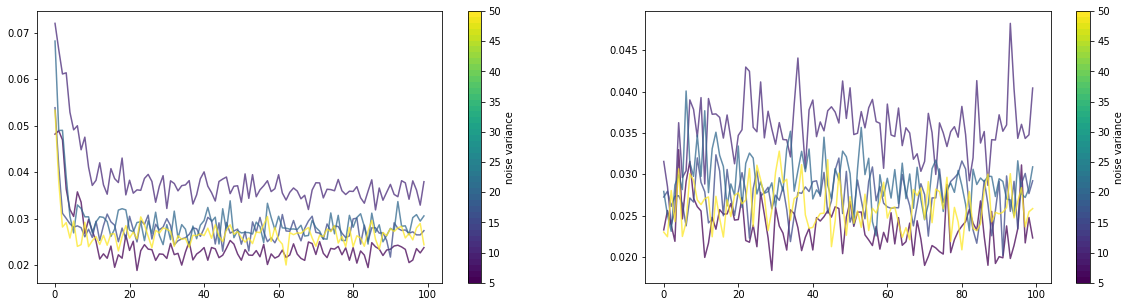

In [30]:
trained = glob(f'./history/splines*')
w = [int(i.split('_')[-1].split('.')[0]) for i in trained]
n = len(trained)+1
viridis = cm.get_cmap('viridis', 256)
colors = viridis(np.linspace(0, 1, np.amax(w)-np.amin(w)+1))
newcmp = ListedColormap(colors)
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))

fig,axs = plt.subplots(ncols=2,figsize=(20,5))

for j,i in enumerate(trained):
    
    v = np.load(i)
    axs[0].plot(v[0],alpha=0.75,color = colors[w[j]-np.amin(w)])
    axs[1].plot(v[1],alpha=0.75,color = colors[w[j]-np.amin(w)])
    
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[0],label='noise variance')
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[1],label='noise variance')
    
plt.show()

# Results

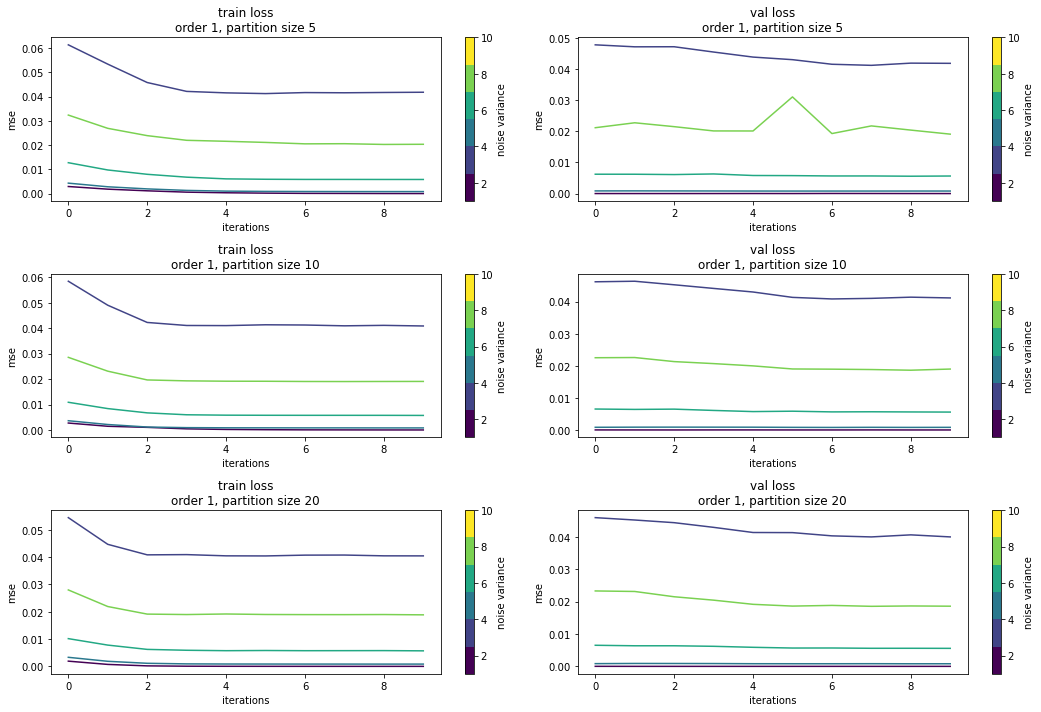

In [2]:
order = 1

classes = np.unique([int(i.split('_')[-2]) for i in glob(f'./history/splines_{typ}*_{order}.npy')])
classes = classes[:-1]
fig,axs = plt.subplots(nrows = len(classes),ncols=2,figsize=(15,10))

for k,num_classes in enumerate(classes):
    #num_classes = 20
    n = len(glob(f'./history/splines_{typ}*{num_classes}_{order}.npy'))+1
    viridis = cm.get_cmap('viridis', 256)
    colors = viridis(np.linspace(0, 1, n))
    newcmp = ListedColormap(colors)


    
    #w = np.arange(0.05,3,0.15)
    ylab = ['mse','mse']
    titles = ['train loss','val loss']
    ct = [tuple(i) for i in colors]

    trained = glob(f'./history/splines_{typ}*{num_classes}_{order}.npy')
    w = [float(i.split('_')[-3]) for i in trained]
    norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))
    for m,i in enumerate(trained):
        hist = np.load(i)
        #c = int(float(i.split('_')[-2])//0.15)
        c = m
        for j in range(len(hist)-1):

            if j%2 == 0:
                im = axs[k,j].plot(np.array(hist[j]),color = colors[c],label=str(w[c]))
            else:
                im = axs[k,j].plot(np.array(hist[j]),color = colors[c],label=str(w[c]))

            axs[k,j].set_title(f'{titles[j]}\norder {order}, partition size {num_classes}')
            axs[k,j].set_xlabel('iterations')
            axs[k,j].set_ylabel(ylab[int(j%2)])


        
    
    
    for j in range(len(hist)-1):
        plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[k,j],label='noise variance')
        

plt.tight_layout()
plt.show()

# Results with first function

In [11]:
order = 1
num_classes = 50
model = get_model("splines",it_lim=10,image_size=image_size,num_classes = num_classes,order=order)

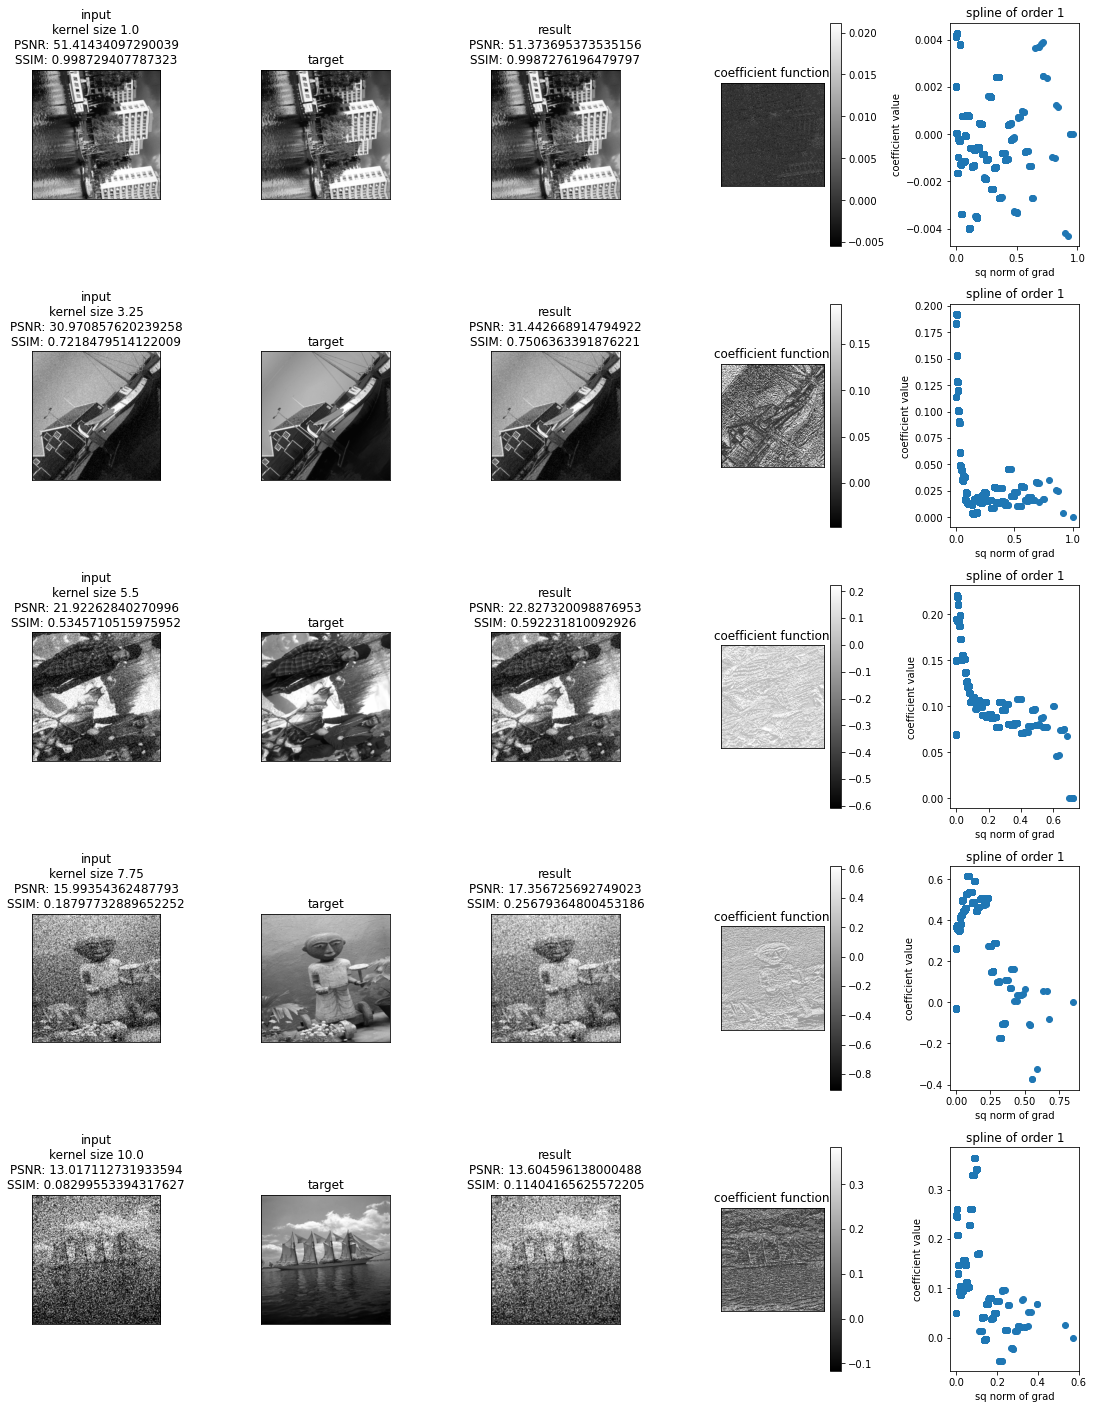

In [12]:


w = np.unique([float(i.split('_')[-3]) for i in glob(f'./checkpoints/splines_{typ}_*_{num_classes}_{order}*')])
fig,axs = plt.subplots(ncols = 5,nrows = int(np.ceil(len(w))),figsize=(15,20))
for i,m in enumerate(w):

    
    model.load_weights(f'./checkpoints/splines_{typ}_{w[i]}_{num_classes}_{order}')
    #im = open_frame(val[_],var = w[i])
    gen_batch_train,gen_batch_val = get_generators(typ,w[i],CROP1=CROP,BATCH_SIZE=5)
    ims = np.array(next(gen_batch_val.as_numpy_iterator()))
    _ = np.random.choice(len(ims[0]))
    im = ims[:,_,...]
    im = np.asarray(im,dtype='float32')
    p = model(ims[0])
    
    #psnr_0 = tf.image.psnr(np.array([np.expand_dims(im[0],axis=-1)]),np.array([np.expand_dims(im[1],axis=-1)]),1)[0]
    #ssim_0 = tf.image.ssim(np.array([np.expand_dims(im[0],axis=-1)]),np.array([np.expand_dims(im[1],axis=-1)]),1)[0]
    psnr_0 = tf.image.psnr(np.array([im[0]]),np.array([im[1]]),1)[0]
    ssim_0 = tf.image.ssim(np.array([im[0]]),np.array([im[1]]),1)[0]
    clean = p[_]
    psnr = tf.image.psnr(np.array([im[1]]),clean,1)[0]
    ssim = tf.image.ssim(np.array([im[1]]),clean,1)[0]
    clean = np.squeeze(clean)
    inputs = tf.keras.Input(shape=image_size + (1,))
    visualization = tf.keras.models.Model(model.input,model.get_layer('coeff_x_0').output)
    vis = visualization(np.array([np.expand_dims(im[1],axis=-1)]))
    get_lambdas = tf.keras.models.Model(model.input,model.get_layer('coeff_spline_0').output)
    spline = np.squeeze(get_lambdas(np.array([np.expand_dims(im[1],axis=-1)])))
    norm_layer = tf.keras.models.Model(model.input,model.get_layer('norm_0').output)
    norm = np.squeeze(norm_layer(np.array([np.expand_dims(im[1],axis=-1)])))
    partition_layer = tf.keras.models.Model(model.input,model.get_layer('partition_0').output)
    partition = np.squeeze(partition_layer(np.array([np.expand_dims(im[1],axis=-1)])))
    
    
    axs[i,0].imshow(im[0],cmap='gray')
    axs[i,0].set_title(f'input\nkernel size {int(100*m)/100}\nPSNR: {psnr_0}\nSSIM: {ssim_0}')
    axs[i,0].set_xticks([])
    axs[i,0].set_xticklabels([])
    axs[i,0].set_yticks([])
    axs[i,0].set_yticklabels([])
    axs[i,1].imshow(im[1],cmap='gray')
    axs[i,1].set_title('target')
    axs[i,1].set_xticks([])
    axs[i,1].set_xticklabels([])
    axs[i,1].set_yticks([])
    axs[i,1].set_yticklabels([])
    axs[i,2].imshow(clean,cmap='gray')
    axs[i,2].set_title(f'result\nPSNR: {psnr}\nSSIM: {ssim}')
    axs[i,2].set_xticks([])
    axs[i,2].set_xticklabels([])
    axs[i,2].set_yticks([])
    axs[i,2].set_yticklabels([])
    im = axs[i,3].imshow(np.squeeze(vis[0]),cmap='gray')
    axs[i,3].set_title('coefficient function')
    plt.colorbar(im,ax=axs[i,3])
    axs[i,3].set_xticks([])
    axs[i,3].set_xticklabels([])
    axs[i,3].set_yticks([])
    axs[i,3].set_yticklabels([])
    
    N = np.ndarray.flatten(norm)
    loc = np.logical_and(N < np.expand_dims(partition[1:],axis=-1),N >= np.expand_dims(partition[:-1],axis=-1))
    power_norm = np.power(np.expand_dims(N,axis=-1),np.reshape(np.arange(order+1),(1,order+1)))
    coeff_plot = np.sum(np.multiply(np.expand_dims(loc.T,axis=-1),spline),axis=1)
    
    fc = np.sum(np.multiply(coeff_plot,power_norm),axis=-1)
    axs[i,4].scatter(N,fc)
    axs[i,4].set_xlabel("sq norm of grad")
    axs[i,4].set_ylabel("coefficient value")
    axs[i,4].set_title(f"spline of order {order}")
    
plt.tight_layout()
plt.show()

# Comparing against Perona Malik

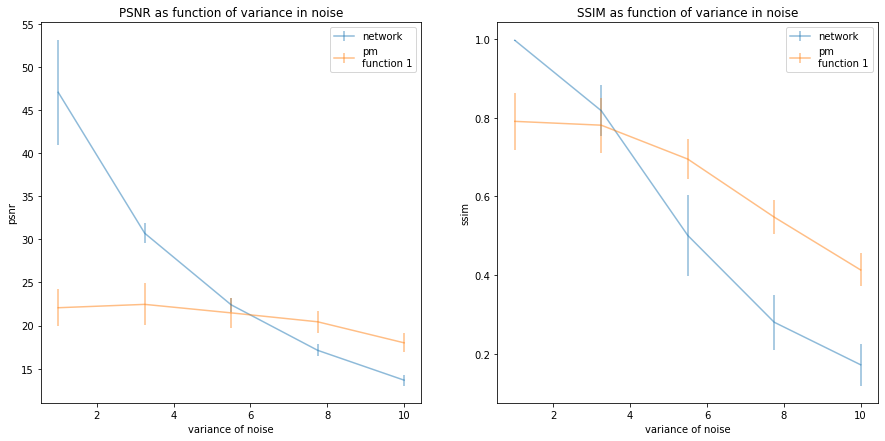

In [5]:
order = 1
num_classes = 50

trained = glob(f'./history/splines_{typ}*1.npy')
w = np.unique([float(i.split('_')[-3]) for i in trained])
psnr_nn_1,psnr_nn_s_1 = [],[]
ssim_nn_1,ssim_nn_s_1 = [],[]

psnr_pm_1,psnr_pm_s_1 = [],[]
ssim_pm_1,ssim_pm_s_1 = [],[]

for i,m in enumerate(w):
    model = get_model("splines",it_lim=10,image_size=image_size,num_classes = num_classes,order=order)
    model.load_weights(f"./checkpoints/splines_{typ}_{w[i]}_{num_classes}_{order}")
    gen_batch_train,gen_batch_val = get_generators(typ,w[i],CROP1=CROP,BATCH_SIZE=100)
    ims = np.array(next(gen_batch_val.as_numpy_iterator()))
    
    res = model(ims[0])
    res = res/np.expand_dims(np.expand_dims(np.amax(res,axis=(1,2)),axis=-2),axis=-2)
    #psnr = tf.image.psnr(res,ims[1],1).numpy()
    #ssim = tf.image.ssim(res,ims[1],1).numpy()
    psnr = [tf.image.psnr(res[j],ims[1][j],1).numpy() for j in range(len(res))]
    ssim = [tf.image.ssim(res[j],ims[1][j],1).numpy() for j in range(len(res))]
    psnr_nn_1.append(np.mean(psnr))
    psnr_nn_s_1.append(np.std(psnr))
    ssim_nn_1.append(np.mean(ssim))
    ssim_nn_s_1.append(np.std(ssim))
    
    pm = np.expand_dims([np.squeeze(anisodiff(im,niter=10,lambd=50,option=1)) for im in ims[0]],axis=-1)
    pm = np.asarray(pm,dtype='float32')
    psnr = [tf.image.psnr(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
    ssim = [tf.image.ssim(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
    psnr_pm_1.append(np.mean(psnr))
    psnr_pm_s_1.append(np.std(psnr))
    ssim_pm_1.append(np.mean(ssim))
    ssim_pm_s_1.append(np.std(ssim))
    
    

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.errorbar(w,psnr_nn_1,psnr_nn_s_1,label='network',alpha=0.5)
plt.errorbar(w,psnr_pm_1,psnr_pm_s_1,label='pm\nfunction 1',alpha=0.5)

#plt.errorbar(w,psnr_nn_2,psnr_nn_s_2,label='network\nfunction 2',alpha=0.5)
#plt.errorbar(w,psnr_pm_2,psnr_pm_s_2,label='pm\nfunction 2',alpha=0.5)
plt.xlabel('variance of noise')
plt.ylabel('psnr')
plt.title('PSNR as function of variance in noise')
plt.legend()

plt.subplot(122)
plt.errorbar(w,ssim_nn_1,ssim_nn_s_1,label='network',alpha=0.5)
plt.errorbar(w,ssim_pm_1,ssim_pm_s_1,label='pm\nfunction 1',alpha=0.5)


plt.xlabel('variance of noise')
plt.ylabel('ssim')
plt.title('SSIM as function of variance in noise')
plt.legend()
plt.show()

In [6]:
order = 1
trained = glob(f'./history/splines_{typ}*1.npy')
w = np.unique([float(i.split('_')[-3]) for i in trained])
ncl = np.unique([int(i.split('_')[-2]) for i in trained])

hist_psnr,hist_ssim = [],[]

for num_classes in ncl:

    psnr_nn_1,ssim_nn_1 = [],[]

    for i,m in enumerate(w):
        model = get_model("splines",it_lim=10,image_size=image_size,num_classes = num_classes,order=order)
        model.load_weights(f"./checkpoints/splines_{typ}_{w[i]}_{num_classes}_{order}")
        gen_batch_train,gen_batch_val = get_generators(typ,w[i],CROP1=CROP,BATCH_SIZE=100)
        ims = np.array(next(gen_batch_val.as_numpy_iterator()))

        res = model(ims[0])
        res = res/np.expand_dims(np.expand_dims(np.amax(res,axis=(1,2)),axis=-2),axis=-2)
        psnr = [tf.image.psnr(res[j],ims[1][j],1).numpy() for j in range(len(res))]
        ssim = [tf.image.ssim(res[j],ims[1][j],1).numpy() for j in range(len(res))]
        psnr_nn_1.append(np.mean(psnr))
        ssim_nn_1.append(np.mean(ssim))


    hist_psnr.append(np.copy(psnr_nn_1))
    hist_ssim.append(np.copy(ssim_nn_1))
    
 

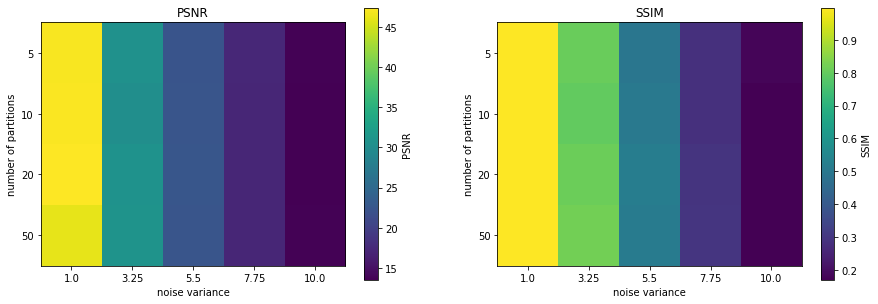

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(hist_psnr)
plt.xlabel('noise variance')
plt.ylabel('number of partitions')
plt.title('PSNR')
plt.colorbar(label='PSNR')
plt.xticks(np.arange(len(w)),w)
plt.yticks(np.arange(len(ncl)),ncl)
plt.subplot(122)
plt.imshow(hist_ssim)
plt.xlabel('noise variance')
plt.ylabel('number of partitions')
plt.title('SSIM')
plt.colorbar(label='SSIM')
plt.xticks(np.arange(len(w)),w)
plt.yticks(np.arange(len(ncl)),ncl)
plt.show()

# Analizing functions for coefficients

In [8]:
R = []
order = 1
trained = glob(f'./history/splines_{typ}*1.npy')
w = np.unique([float(i.split('_')[-3]) for i in trained])
ncl = np.unique([int(i.split('_')[-2]) for i in trained])

for num_classes in ncl:
    R.append([])
    model = get_model("splines",it_lim=1,image_size=image_size,num_classes = num_classes,order=order)
    
    for i,m in enumerate(tqdm(w)):

        
        model.load_weights(f"./checkpoints/splines_{typ}_{w[i]}_{num_classes}_{order}")
        
        temp_mean = [[] for c in range(num_classes)]
        gen_batch_train,gen_batch_val = get_generators(typ,w[i],CROP1=CROP,BATCH_SIZE=50)
        xs, ys = next(gen_batch_train.as_numpy_iterator())
        for _ in range(len(xs)):


            xs[_]
            get_lambdas = tf.keras.models.Model(model.input,model.get_layer('coeff_spline_0').output)
            spline = np.squeeze(get_lambdas(np.array([np.expand_dims(xs[_],axis=-1)])))
            norm_layer = tf.keras.models.Model(model.input,model.get_layer('norm_0').output)
            norm = np.squeeze(norm_layer(np.array([np.expand_dims(xs[_],axis=-1)])))
            partition_layer = tf.keras.models.Model(model.input,model.get_layer('partition_0').output)
            partition = np.squeeze(partition_layer(np.array([np.expand_dims(xs[_],axis=-1)])))
            #partition = np.amax(N)*partition/np.amax(partition)

            N = np.ndarray.flatten(norm)
            loc = np.logical_and(N < np.expand_dims(partition[1:],axis=-1),N >= np.expand_dims(partition[:-1],axis=-1))
            power_norm = np.power(np.expand_dims(N,axis=-1),np.reshape(np.arange(order+1),(1,order+1)))
            coeff_plot = np.sum(np.multiply(np.expand_dims(loc.T,axis=-1),spline),axis=1)

            fc = np.sum(np.multiply(coeff_plot,power_norm),axis=-1)

            classes = np.argmax(loc,axis = 0)
            for c in range(num_classes):
                temp_mean[c] = np.concatenate((temp_mean[c],fc[np.argmax(loc,axis=0) == c]))
                temp_mean[c] = np.nan_to_num(temp_mean[c])

        mean = [np.mean(j) for j in temp_mean]
        std = [np.std(j) for j in temp_mean]

        R[-1].append(np.transpose([mean,std]))

100%|█████████████████████████████████████████████| 5/5 [00:17<00:00,  3.46s/it]


100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.63s/it]


100%|█████████████████████████████████████████████| 5/5 [00:22<00:00,  4.59s/it]


100%|█████████████████████████████████████████████| 5/5 [00:43<00:00,  8.63s/it]


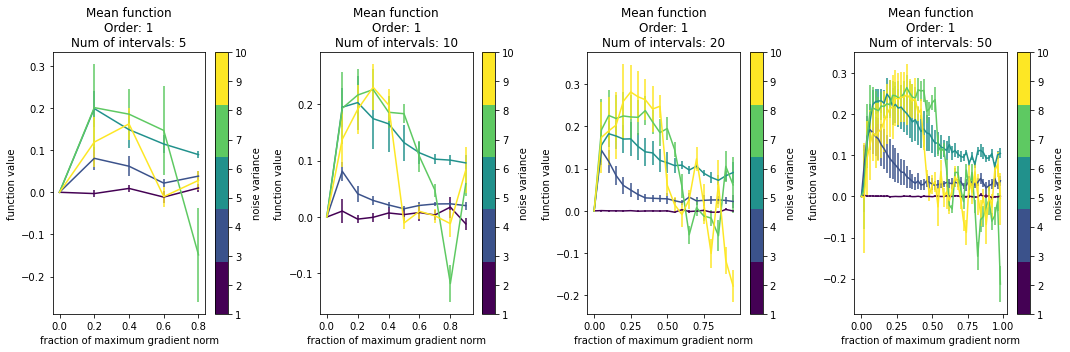

In [9]:
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))

fig,axs = plt.subplots(ncols = len(R),nrows = 1,figsize=(15,5))
orders,num_classes = [1,2,3,5],[5,10,20]

for col in range(len(R)):
        
    if len(R[col]) == 0:
        continue

    viridis = cm.get_cmap('viridis', 256)
    colors = viridis(np.linspace(0, 1, len(R[col])))
    newcmp = ListedColormap(colors)

    for i in range(len(R[col])):

        m,s = R[col][i].T

        axs[col].errorbar(np.arange(len(m))/ncl[col],m,s,color=colors[i])

    axs[col].set_title(f"Mean function\nOrder: {1}\nNum of intervals: {ncl[col]}")
    axs[col].set_xlabel("fraction of maximum gradient norm")
    axs[col].set_ylabel("function value")
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[col],label='noise variance')

plt.tight_layout()        
plt.show()